1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


Covariance matrix:
[[ 0.964  0.808  2.737]
 [ 0.808  9.865 11.481]
 [ 2.737 11.481 16.954]]
l:
[25.716 -0.     2.067]
V:
[[-0.108 -0.816  0.567]
 [-0.587 -0.408 -0.699]
 [-0.803  0.408  0.435]]
V.T:
[[-0.108 -0.587 -0.803]
 [-0.816 -0.408  0.408]
 [ 0.567 -0.699  0.435]]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

l_svd:
[25.717  2.068  0.   ]
V_svd:
[[-0.108  0.567 -0.816]
 [-0.587 -0.699 -0.408]
 [-0.803  0.435  0.408]]
Results are considered very similiar, with differences caused by approximation in computations, if we conveniently exchange columns
The variability explained by the principal components is (from l_svd):
[0.926 0.074 0.   ]
So if we use only first feature we can explain a variability of 92.56%
2nd and 3rd feature are constructed on 1st feature, therefore it makes sense that variability explained by them is lower with respect to 1st feature.
To retain at least 99% of variability we need at least 2 components (= 100.00%).


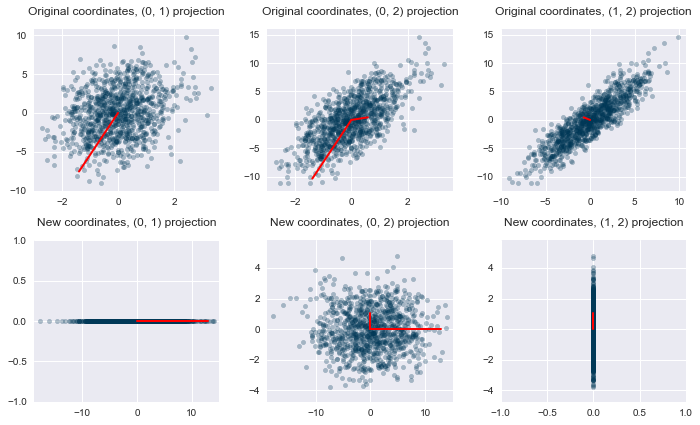

In [86]:
import numpy as np
import numpy.random as npr
import scipy.linalg as la
from IPython.display import display, Math, Latex
import matplotlib.pyplot as plt

%precision 4
np.set_printoptions(suppress=True)
# 1 - Initialization
N = 1000
rng = npr.default_rng()
x1 = rng.normal(loc=0, scale=1, size=(1,N))
x2 = x1 + rng.normal(loc=0, scale=3, size=(1,N))
x3 = 2*x1 + x2
X = np.vstack((x1, x2, x3))

# 2 - We use Principal Component Analysis
cov = np.cov(X)
print("Covariance matrix:")
print(cov)
# l: eigenvalues, V: eigenvectors
l, V = la.eig(cov)
l = np.real_if_close(l)
print("l:"); print(l)
print("V:"); print(V)
print("V.T:"); print(V.T)
# 3 - SVD
U, spectrum, Vt = la.svd(X)
# For comparison
l_svd = spectrum**2/(N-1)
V_svd = U
D = np.zeros((U.shape[1], Vt.shape[0]))
for i in range(spectrum.shape[0]):
    D[i,i] = spectrum[i]
SVD = U@D@Vt
display(Latex(r'Max absolute difference between covariance matrix and $V l V^{-1}$: '
              + "%.3e" % np.amax(np.abs(cov - V@np.diag(l)@la.inv(V))) ))
display(Latex(r'Max absolute difference between dataset and $U D V^T$: '
              + "%.3e" % np.amax(np.abs(X - SVD)) ))
print("l_svd:"); print(l_svd)
print("V_svd:"); print(V_svd)
print("Results are considered very similiar, with differences caused by approximation in computations, \
if we conveniently exchange columns")
# For that, we could reorder l's rows and V's columns to match with SVD
order = [0,2,1]
l_ord = l[order]
V_ord = V[:,order]

# 4 - Variability
print("The variability explained by the principal components is (from l_svd):")
variability = l_svd/np.sum(l_svd)
print(variability)
print(f"So if we use only first feature we can explain a variability of {variability[0]*100:.2f}%")
print("2nd and 3rd feature are constructed on 1st feature, therefore it makes sense that \
variability explained by them is lower with respect to 1st feature.")
n99 = -1 # #n components needed to retain 99% variability
for i in range(variability.shape[0]):
    if np.sum(variability[:i]) >= 0.99:
        n99 = i
        break
if n99 != -1:
    print(f"To retain at least 99% of variability we need at least {n99} \
components (= {np.sum(variability[:n99])*100:.2f}%).")
else:
    print("With current components it's not possible to explain 99% of variability.")
# We could write more complex code but we know it's only 3rd feature to be deleted
X_reduced = X.copy()
X_reduced[2].fill(0)

# 5 - Change of base
Xp = V.T @X

# 6 - Plotting
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
fig.tight_layout(pad=2, h_pad=3)
plt.style.use('seaborn')
alpha = 0.3
color = "#003857" # blue
projections = ((0,1), (0,2), (1,2))
scale = 0.5
for i,c in enumerate(projections):
    c0, c1 = c[0], c[1]
    ax[0,i].scatter(X[c0,:], X[c1,:], alpha=alpha, color=color, s=20)
    ax[0,i].set_title(f"Original coordinates, ({c0}, {c1}) projection", y=1.05)
    ax[1,i].scatter(Xp[c0,:], Xp[c1,:], alpha=alpha, color=color, s=20)
    ax[1,i].set_title(f"New coordinates, ({c0}, {c1}) projection", y=1.05)
    for li, vi in zip(l[[c0,c1]], V.T[[c0,c1]]):
        ax[0,i].plot([0, scale*li*vi[c0]], [0, scale*li*vi[c1]], 'r-', lw=2)
    for li, vi in zip(l[[c0,c1]], np.identity(2)):
        ax[1,i].plot([0, scale*li*vi[0]], [0, scale*li*vi[1]], 'r-', lw=2)
        limits = [np.min(Xp[c0,:])-1,np.max(Xp[c0,:])+1,np.min(Xp[c1,:])-1,np.max(Xp[c1,:])+1]
        ax[1,i].axis(limits)

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [211]:
num_noises = 10
noise = np.zeros((num_noises,N))
for i in range(num_noises):
    noise[i] = rng.normal(loc=0, scale=1/(45+i), size=(1,N))
X_noised = np.vstack((X,noise))
U_n, spectrum_n, Vt_n = la.svd(X_noised)
l_svd_n = spectrum_n**2/(N-1)
variability_n = l_svd_n/np.sum(l_svd_n)
print("Variability:"); print(variability_n)
print("We can retain same variability as before (~100%) deleting 3rd feature and new noise.\
This is because noise is \"small\" and doesn't contribute to variability of data.")
print("If noise is bigger, it could contribute to variability in a not negligible way")
noise2 = np.zeros((num_noises,N))
for i in range(num_noises):
    noise2[i] = rng.normal(loc=0, scale=1/(1+i), size=(1,N))
U2, s2, Vt2 = la.svd(np.vstack((X, noise2)))
lsvd2 = s2**2/(N-1)
var2 = lsvd2/np.sum(lsvd2)
print("New variability:"); print(var2)

Variability:
[0.9369 0.063  0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
We can retain same variability as before (~100%) deleting 3rd feature and new noise.This is because noise is "small" and doesn't contribute to variability of data.
If noise is bigger, it could contribute to variability in a not negligible way
New variability:
[0.8919 0.0601 0.0313 0.0078 0.0035 0.0018 0.0012 0.0008 0.0006 0.0005
 0.0004 0.0003 0.    ]


3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.



Variability:
[ 0.979  0.021  0.     0.     0.    -0.    -0.    -0.    -0.    -0.
 -0.     0.     0.     0.     0.     0.    -0.     0.     0.     0.
  0.     0.     0.     0.     0.    -0.    -0.    -0.    -0.    -0.
  0.     0.     0.    -0.    -0.    -0.    -0.    -0.     0.     0.
 -0.    -0.    -0.    -0.    -0.     0.     0.     0.     0.    -0.
  0.    -0.    -0.     0.     0.     0.    -0.    -0.    -0.     0.
  0.     0.     0.   ]
It seems obvious that, in practice, only the first list of measurements, i.e. of those along x, is the one that only matters.
We do a scatterplot of first two components


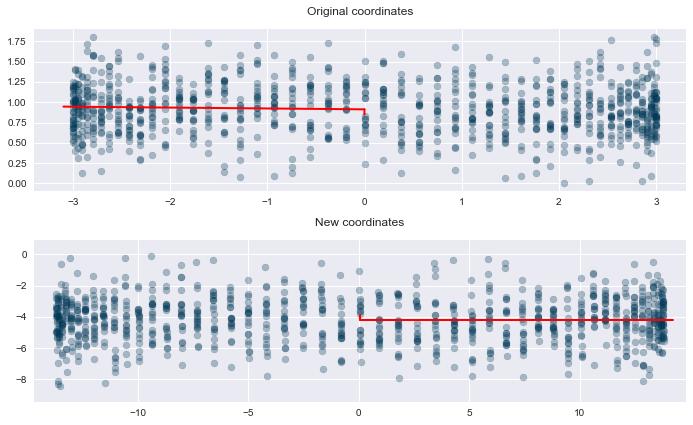

In [175]:
import numpy as np
import numpy.random as npr
from scipy.spatial.transform import Rotation
import scipy.linalg as la
import matplotlib.pyplot as plt
N = 1000
n_cameras = 20
# records[0] = x, records[1] = y, records[2] = z (= 0)
records = np.zeros((3,N))
A, omega, phi = 3, 10*(2*np.pi), 0.3*(2*np.pi)
records[0] = A*np.cos(omega*np.arange(N)/1000 + phi)
records[1] = rng.normal(loc=0, scale=A/10, size=(1,N))
# We ask for y >= 0
records[1] -= np.min(records[1])
# Rotation function
def R(theta, phi):
    return Rotation.from_euler("zxy", [theta, 0, phi], degrees=True).as_matrix()
# Cameras' views
rotated = np.zeros((n_cameras*3, N))
rng = npr.default_rng()
for i in range(n_cameras):
    theta, phi = rng.integers(0, 360), rng.integers(0, 180)
    rotated[3*i:3*i+3] = R(theta, phi) @ records
# PCA part
X = np.vstack((records, rotated))
means = np.mean(X, axis=1)
l, V = la.eig(np.cov(X))
l = np.real_if_close(l)
V = np.real_if_close(V)
variability = l/np.sum(l)
print("Variability:")
print(variability)
print("It seems obvious that, in practice, only the first list of measurements, \
i.e. of those along x, is the one that only matters.")
print("We do a scatterplot of first two components")
Xp = V.T @ X
Xp = np.real_if_close(Xp)
meansp = np.mean(Xp, axis=1)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
fig.tight_layout(pad=2, h_pad=3)
plt.style.use('seaborn')
alpha = 0.3
color = "#003857" # blue
projections = ((0,1),)
scale = 0.15
ax[0].scatter(X[0,:], X[1,:], alpha=alpha, color=color)
ax[0].set_title("Original coordinates", y=1.05)
ax[1].scatter(Xp[0,:], Xp[1,:], alpha=alpha, color=color)
ax[1].set_title("New coordinates", y=1.05)
mx, my = means[0], means[1]
mxp, myp = meansp[0], meansp[1]
for li, vi in zip(l[[0,1]], V.T[[0,1]]):
    vi = np.real_if_close(vi)
    ax[0].plot([mx, mx+scale*li*vi[0]], [my, my+scale*li*vi[1]], 'r-', lw=2)
for li, vi in zip(l[[0,1]], np.identity(2)):
    ax[1].plot([mxp, mxp+scale*li*vi[0]], [myp, myp+scale*li*vi[1]], 'r-', lw=2)
    limits = [np.min(Xp[0,:])-1,np.max(Xp[0,:])+1,np.min(Xp[1,:])-1,np.max(Xp[1,:])+1]
    ax[1].axis(limits)

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

In [87]:
import numpy as np
import scipy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)
filename = "data/magic04.data"
# from "data/magic04.names"
# all attributes continuous except "class", with values in {"g", "h"}
attributes = ("fLength", "fWidth", "fSize", "fConc", "fConcl", "fAsym",
              "fM3Long", "fM3Trans", "fAlpha", "fDist", "class")
data = pd.read_csv(filename, names=attributes)
print(data.head())
print("\n")
# data as np.ndarray
X = (data.values).T
# "g" => 0, "h" => 1
X = np.vstack((X[:-1], X[-1]=="h"))
X = X.astype(np.float)
# PCA from Covariance matrix
l, V = la.eig(np.cov(X))
l = np.real_if_close(l)
variability_cov = l/np.sum(l)
print("Variability obtained using covariance matrix:")
print(variability_cov)
# PCA from SVD
# We first need to translate data
means = np.mean(X, axis=1)
Xstd = X.copy()
for i in range(Xstd.shape[0]):
    Xstd[i] -= means[i]
# Actual SVD
U, spectrum, Vt = la.svd(Xstd)
l_svd = spectrum**2/(Xstd.shape[1])
variability_svd = l_svd/np.sum(l_svd)
print("Variability obtained using SVD:")
print(variability_svd)
print(f"We decide to retain 95% of variability. That means we only need first 5 features \
({np.sum(variability_cov[:5])*100:.2f}%)")

    fLength    fWidth   fSize   fConc  fConcl     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g  


Variability obtained using covariance matrix:
[0.44  0.258 0.135 0.089 0.041 0.029 0.008 0.    0.    0.    0.   ]
Variability obtained using SVD:
[0.44  0.258 0.135 0.089 0.041 0.029 0.008 0.    0.    0.    0.   ]
We decide to retain 95% of variability. That means we only need first 5 features (96.31%)


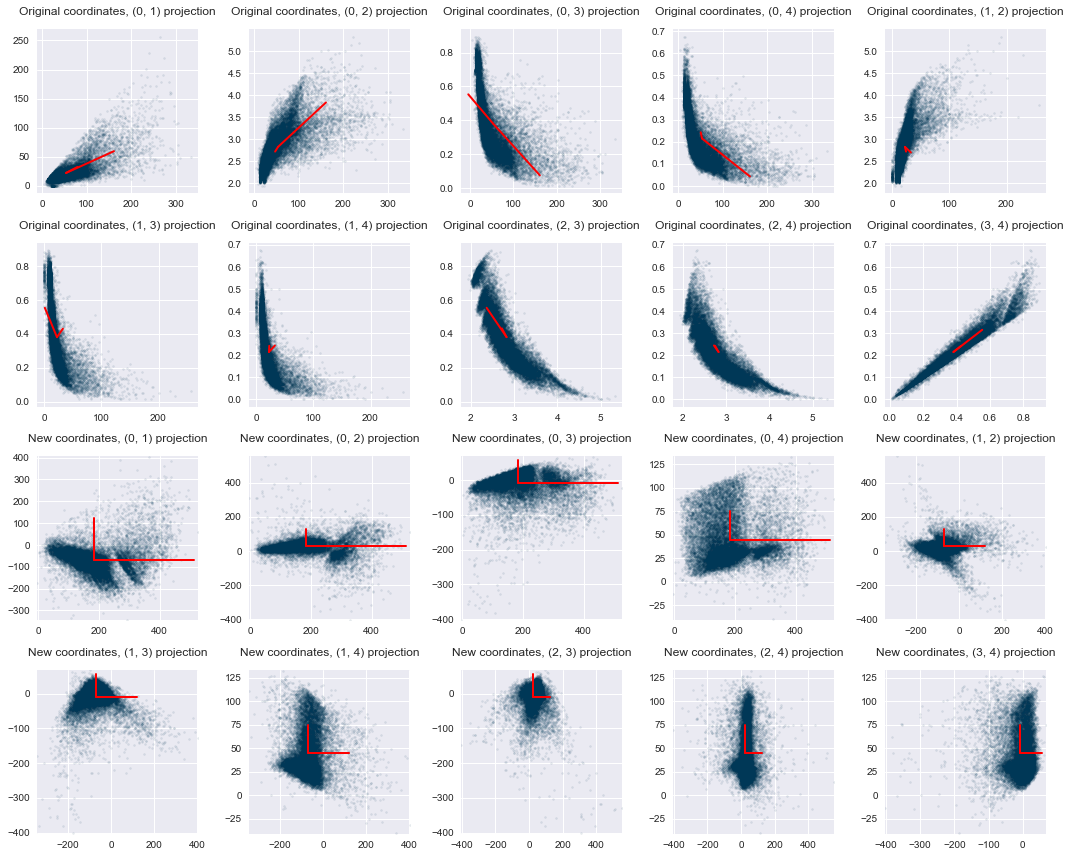

In [84]:
# New coordinates
Xp = V.T@X
meansp = np.mean(Xp, axis=1)
# Plotting
projections = ((0,1), (0,2), (0,3), (0,4), (1,2), (1,3), (1,4), (2,3), (2,4), (3,4))
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,12))
fig.tight_layout(pad=2, h_pad=3)
plt.style.use('seaborn')
alpha = 0.1
color = "#003857" # blue
scale = 0.05
for i,c in enumerate(projections):
    c0, c1 = c[0], c[1]
    # Indices to transform i, from 1D array, to a 2D array
    i_row = i//5
    i_col = i%5
    ax[0+i_row,i_col].scatter(X[c0,:], X[c1,:], alpha=alpha, color=color, s=4)
    ax[0+i_row,i_col].set_title(f"Original coordinates, ({c0}, {c1}) projection", y=1.05)
    ax[2+i_row,i_col].scatter(Xp[c0,:], Xp[c1,:], alpha=alpha, color=color, s=4)
    ax[2+i_row,i_col].set_title(f"New coordinates, ({c0}, {c1}) projection", y=1.05)
    for li, vi in zip(l[[c0,c1]], V.T[[c0,c1]]):
        mx, my = means[c0], means[c1]
        ax[0+i_row,i_col].plot([mx, mx+scale*li*vi[c0]], [my, my+scale*li*vi[c1]], 'r-', lw=2)
        # In (0,3) projection it seems to be some kind of a problem.
        # There actually are 2 different eigenvectors and they are almost parallel
    for li, vi in zip(l[[c0,c1]], np.identity(2)):
        mx, my = meansp[c0], meansp[c1]
        ax[2+i_row,i_col].plot([mx, mx+scale*li*vi[0]], [my, my+scale*li*vi[1]], 'r-', lw=2)
        limits = [np.min(Xp[c0,:])-1,np.max(Xp[c0,:])+1,np.min(Xp[c1,:])-1,np.max(Xp[c1,:])+1]
        ax[2+i_row,i_col].axis(limits)